In [10]:
import pandas as pd
import numpy as np
from datetime import date
import holidays
from prophet import Prophet

import datetime
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)
state = np.random.RandomState(12345)

In [11]:
pr_df = pd.read_csv('D:\data_science\demand_forecast_for_products\sp_sales_task\pr_df.csv')
sales_df = pd.read_csv('D:\data_science\demand_forecast_for_products\sp_sales_task\sales_df_train.csv')
sales_submission = pd.read_csv('D:\data_science\demand_forecast_for_products\sp_sales_task\sales_submission.csv')
st_df = pd.read_csv('D:\data_science\demand_forecast_for_products\sp_sales_task\st_df.csv')

In [12]:
# Соединяем все таблицы
df_1 = pd.merge(sales_df, st_df, how='left', left_on='st_id', right_on='st_id')
df = pd.merge(df_1, pr_df, how='left', left_on='pr_sku_id', right_on='pr_sku_id')

In [13]:
# df['fe_st_id'] = df['st_id'].map(df['st_id'].value_counts(normalize=False))
# df['fe_pr_sku_id'] = df['pr_sku_id'].map(df['pr_sku_id'].value_counts(normalize=False))
# df['fe_st_city_id'] = df['st_city_id'].map(df['st_city_id'].value_counts(normalize=False))
# df['fe_st_division_code'] = df['st_division_code'].map(df['st_division_code'].value_counts(normalize=False))
# df['fe_pr_group_id'] = df['pr_group_id'].map(df['pr_group_id'].value_counts(normalize=False))
# df['fe_pr_cat_id'] = df['pr_cat_id'].map(df['pr_cat_id'].value_counts(normalize=False))
# df['fe_pr_subcat_id'] = df['pr_subcat_id'].map(df['pr_subcat_id'].value_counts(normalize=False))

In [14]:
df = df.rename(columns = {'pr_sales_in_rub' : 'y'})

In [15]:
df['ds'] = pd.to_datetime(df['date'])

In [16]:
# df = df.drop(['st_id', 'pr_sku_id', 'st_city_id',
#               'st_division_code', 'pr_group_id',
#                   'pr_cat_id', 'pr_subcat_id',
#                   'pr_promo_sales_in_units',
#                    'pr_promo_sales_in_rub', 'date'], axis=1)

In [17]:
df = df.drop(['pr_promo_sales_in_units',
                   'pr_promo_sales_in_rub',
                    'pr_sales_in_units', 'date'], axis=1)

In [18]:
df.dropna (how='all')

,st_id,pr_sku_id,pr_sales_type_id,y,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,ds
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,1,825.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,2022-10-20
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,0,196.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,17,2023-01-29
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,0,78.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,17,2023-03-02
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,1,69.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,a13b7a6b8e80d44d044c257a08ecccca,1,2023-04-05
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,0,161.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,0d51481bbf77027ddb2c990cf97cd9dd,1,2023-02-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883010,c81e728d9d4c2f636f067f89cc14862c,a0150fefa71d6606d5e642fa0e7b8ad8,1,33.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,8ec316a6bd7240d74c0567a1d9b311e5,17,2022-12-13
883011,42a0e188f5033bc65bf8d78622277c4e,5b146d93f822459260216df28e572eca,0,192.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,6bae9a61fa499b24f28c3ddcef6ccb1b,1,2023-04-18
883012,42a0e188f5033bc65bf8d78622277c4e,c8bd18ea08d2f47cb0a7992f11ada9de,0,970.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,aab3238922bcc25a6f606eb525ffdc56,186a157b2992e7daed3677ce8e9fe40f,aa36dc1d45661519a5bf923429776a83,1,2022-08-16
883013,f7e6c85504ce6e82442c770f7c8606f0,b960c6ee5b5efa12e73f810204b561a8,0,262.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,8ec316a6bd7240d74c0567a1d9b311e5,17,2023-04-23


In [19]:
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RUS(years=(2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.tail(10)

,ds,holiday
20,2023-01-07,Рождество Христово
21,2023-01-08,Новогодние каникулы
22,2023-02-23,День защитника Отечества
23,2023-02-24,День защитника Отечества
24,2023-03-08,Международный женский день
25,2023-05-01,Праздник Весны и Труда
26,2023-05-08,День Победы
27,2023-05-09,День Победы
28,2023-06-12,День России
29,2023-11-04,День народного единства


In [20]:
# Период, который надо отрезать и предсказать (проверка модели)
date_lag = 15
predictions = df['ds'].max() - timedelta(date_lag)

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = df.loc[df['ds'] < predictions]

In [21]:
m = Prophet(holidays=df_holidays, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(train_df)

21:14:52 - cmdstanpy - INFO - Chain [1] start processing
21:15:29 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# Предсказываем 15 дней
future = m.make_future_dataframe(periods=date_lag)
forecast = m.predict(future)

C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


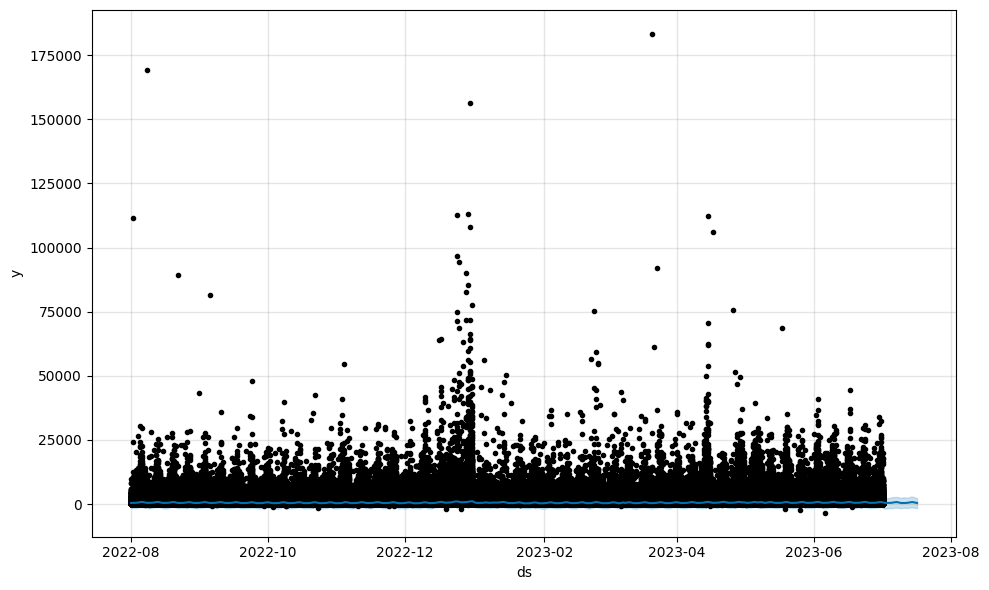

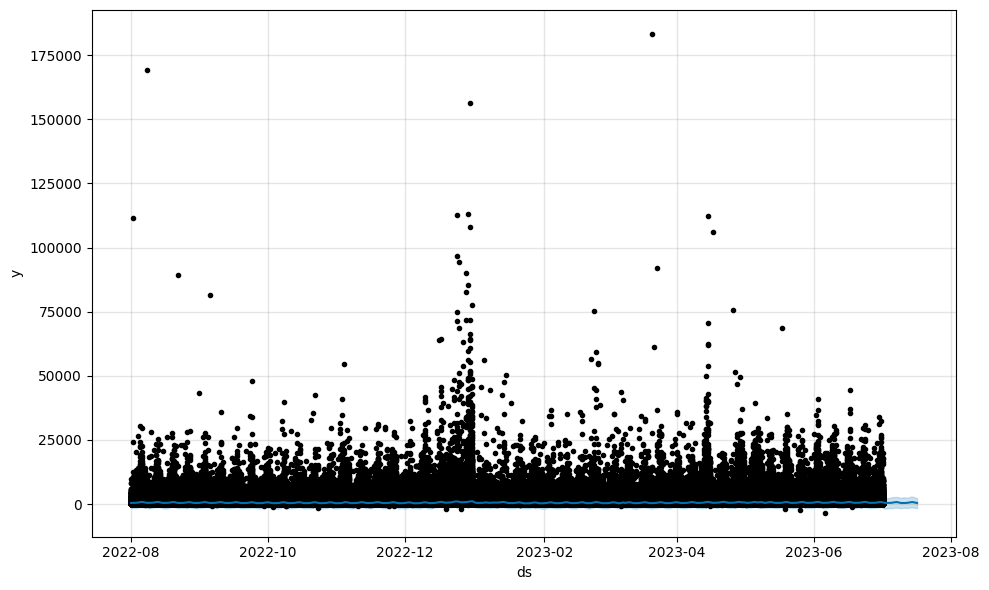

In [23]:
# Смотрим, что предсказалось
m.plot(forecast)

C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:349: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Lo

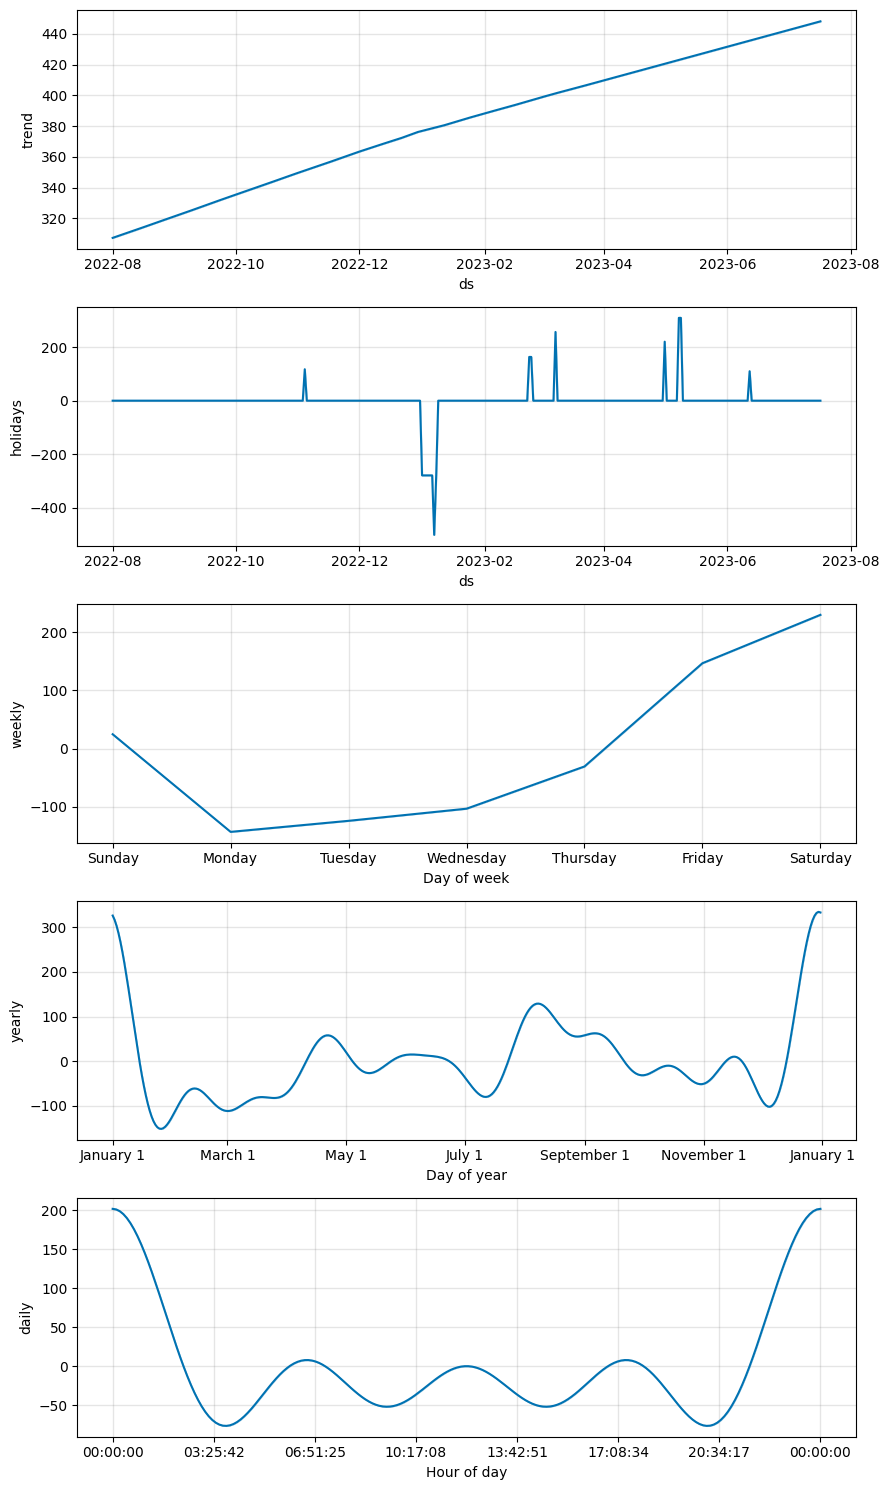

In [24]:
# Смотрим по компонентам
m.plot_components(forecast);

In [25]:
# Объединяем первоначальную таблицу и таблицу с признаками и таргетом
df_test = df.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

In [26]:
# Для вычисления метрики берем только отрезанную часть датасета
df_metric = df_test[df_test['ds'] > predictions]

In [27]:
# Вычисляем метрику
wape = 100 * (df_metric['y'] - df_metric['yhat']).abs().sum() / df_metric['y'].sum()
wape

92.61521595187865

In [37]:
df_test[df_test['ds'] == '2023-02-17'].head()

,st_id,pr_sku_id,pr_sales_type_id,y,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,ds,yhat,yhat_lower,yhat_upper
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,0,161.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,0d51481bbf77027ddb2c990cf97cd9dd,1,2023-02-17,672.52969,-1334.226135,2771.693622
18,42a0e188f5033bc65bf8d78622277c4e,a9e6d9a4ffe9ece67328c36bf09741bc,0,778.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,6512bd43d9caa6e02c990b0a82652dca,e58cc5ca94270acaceed13bc82dfedf7,c0a667df8f0d6ee98dda972b0870fabf,1,2023-02-17,672.52969,-1334.226135,2771.693622
215,16a5cdae362b8d27a1d8f8c7b78b4330,2e463fcb1369be4d5dfbe87e04f60df2,1,305.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,b9d194b4fcd411b02eea6fe9f66bf427,1,2023-02-17,672.52969,-1334.226135,2771.693622
788,6364d3f0f495b6ab9dcf8d3b5c6e0b01,e6fc24ca846339d204b0b50e9f772484,1,36.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,0d51481bbf77027ddb2c990cf97cd9dd,1,2023-02-17,672.52969,-1334.226135,2771.693622
838,6364d3f0f495b6ab9dcf8d3b5c6e0b01,ce594d50580ad4bb23826e7b8be5e15f,1,329.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,c20ad4d76fe97759aa27a0c99bff6710,fb2fcd534b0ff3bbed73cc51df620323,45551f4c29881972ae5ed3666a5b1b8b,1,2023-02-17,672.52969,-1334.226135,2771.693622


In [29]:
future

,ds
0,2022-08-01
1,2022-08-02
2,2022-08-03
3,2022-08-04
4,2022-08-05
...,...
346,2023-07-13
347,2023-07-14
348,2023-07-15
349,2023-07-16
